<a href="https://colab.research.google.com/github/zinseo964/dam_flow/blob/main/hr_dam_rnn(includesthepreviousdam).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
""" RNN dam flow prediction: stacked RNN """

# import libraries
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/240410/data_hr - data_hr.csv', encoding='utf-8')

In [ ]:
data = data.fillna(0)
data = data[26280:]
data = data.reset_index(drop=True, inplace=False)

In [ ]:
original_dam = data['dam']

In [ ]:
dam = data.drop(['date','90','100','101','211','212'], axis = 1)

In [ ]:
print(data)

                    date      dam   90  100  101  211  212
0        2002-12-31 0:00   70.300  0.0  0.0  0.0  0.0  0.0
1        2002-12-31 1:00   15.400  0.0  0.0  0.0  0.0  0.0
2        2002-12-31 2:00   65.200  0.0  0.0  0.0  0.0  0.0
3        2002-12-31 3:00  150.800  0.0  0.0  0.0  0.0  0.0
4        2002-12-31 4:00   87.700  0.0  0.0  0.0  0.0  0.0
...                  ...      ...  ...  ...  ...  ...  ...
184099  2023-12-31 19:00  173.106  0.0  0.0  0.0  0.0  0.0
184100  2023-12-31 20:00    0.000  0.0  0.0  0.0  0.0  0.0
184101  2023-12-31 21:00  124.118  0.0  0.0  0.0  0.0  0.0
184102  2023-12-31 22:00   15.417  0.0  0.0  0.0  0.0  0.0
184103  2023-12-31 23:00    0.000  0.0  0.0  0.0  0.0  0.0

[184104 rows x 7 columns]


In [ ]:
dates = pd.to_datetime(data['date'])

In [ ]:
# variables for training
cols = list(data)[1:7]

In [ ]:
print(cols)

['dam', '90', '100', '101', '211', '212']


In [ ]:
# new dataframe with only training data - 5 columns
data = data[cols].astype(float)

In [ ]:
# normalize the dataset
scaler = MinMaxScaler(feature_range = (0,1))
dam_data_scaled = scaler.fit_transform(data)

scaler_dam = MinMaxScaler(feature_range=(0,1))
dam_scaled = scaler_dam.fit_transform(dam)

In [ ]:
# scaler = StandardScaler()
# dam_data_scaled = scaler.fit_transform(data)

# scaler_dam = StandardScaler()
# dam_scaled = scaler_dam.fit_transform(dam)

In [ ]:
print(dam_data_scaled)

[[-0.06832024 -0.13967454 -0.15138245 -0.12638031 -0.13115196 -0.12862766]
 [-0.28957243 -0.13967454 -0.15138245 -0.12638031 -0.13115196 -0.12862766]
 [-0.08887372 -0.13967454 -0.15138245 -0.12638031 -0.13115196 -0.12862766]
 ...
 [ 0.1485714  -0.13967454 -0.15138245 -0.12638031 -0.13115196 -0.12862766]
 [-0.28950392 -0.13967454 -0.15138245 -0.12638031 -0.13115196 -0.12862766]
 [-0.35163589 -0.13967454 -0.15138245 -0.12638031 -0.13115196 -0.12862766]]


In [ ]:
# split to train data and test data
n_train = int(0.9*dam_data_scaled.shape[0])
train_data_scaled = dam_data_scaled[0: n_train]
train_dates = dates[0: n_train]

test_data_scaled = dam_data_scaled[n_train:]
test_dates = dates[n_train:]
print(test_dates.head(5))

165693   2021-11-24 21:00:00
165694   2021-11-24 22:00:00
165695   2021-11-24 23:00:00
165696   2021-11-25 00:00:00
165697   2021-11-25 01:00:00
Name: date, dtype: datetime64[ns]


In [ ]:
print(train_data_scaled)

[[0.00663526 0.         0.         0.         0.         0.        ]
 [0.00145353 0.         0.         0.         0.         0.        ]
 [0.0061539  0.         0.         0.         0.         0.        ]
 ...
 [0.         0.         0.         0.         0.         0.        ]
 [0.00753607 0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]


In [ ]:
# data reformatting for LSTM
pred_days = 1  # prediction period
seq_len = 24   # sequence length = past days for future prediction.
input_dim = 6  # input_dimension = ['dam', '90', '100', '101', '211', '212']

trainX = []
trainY = []
testX = []
testY = []

for i in range(seq_len, n_train-pred_days +1):
    trainX.append(train_data_scaled[i - seq_len:i, 0:train_data_scaled.shape[1]])
    trainY.append(train_data_scaled[i + pred_days - 1:i + pred_days, 0])

for i in range(seq_len, len(test_data_scaled)-pred_days +1):
    testX.append(test_data_scaled[i - seq_len:i, 0:test_data_scaled.shape[1]])
    testY.append(test_data_scaled[i + pred_days - 1:i + pred_days, 0])

print(trainX[1][-1])
print(trainY[0])

trainX, trainY = np.array(trainX), np.array(trainY)
testX, testY = np.array(testX), np.array(testY)

[0.01005199 0.         0.         0.         0.         0.        ]
[0.01005199]


In [ ]:
print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

(165669, 24, 6) (165669, 1)
(18387, 24, 6) (18387, 1)


In [ ]:
print(data)

            dam   90  100  101  211  212
0        70.300  0.0  0.0  0.0  0.0  0.0
1        15.400  0.0  0.0  0.0  0.0  0.0
2        65.200  0.0  0.0  0.0  0.0  0.0
3       150.800  0.0  0.0  0.0  0.0  0.0
4        87.700  0.0  0.0  0.0  0.0  0.0
...         ...  ...  ...  ...  ...  ...
184099  173.106  0.0  0.0  0.0  0.0  0.0
184100    0.000  0.0  0.0  0.0  0.0  0.0
184101  124.118  0.0  0.0  0.0  0.0  0.0
184102   15.417  0.0  0.0  0.0  0.0  0.0
184103    0.000  0.0  0.0  0.0  0.0  0.0

[184104 rows x 6 columns]


In [ ]:
# RNN model
model = Sequential()
model.add(Flatten(input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(64))
model.add(Dense(32))
model.add(Dense(trainY.shape[1]))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 144)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                9280      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 11393 (44.50 KB)
Trainable params: 11393 (44.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# specify your learning rate
learning_rate = 0.01
# create an Adam optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)
# compile your model using the custom optimizer
model.compile(optimizer=optimizer, loss='mse')

No weights found, training model from scratch
Epoch 1/30
4660/4660 [==============================] - 13s 3ms/step - loss: 2.0703e-04 - val_loss: 1.9614e-04
Epoch 2/30
4660/4660 [==============================] - 13s 3ms/step - loss: 1.6629e-04 - val_loss: 1.7569e-04
Epoch 3/30
4660/4660 [==============================] - 12s 3ms/step - loss: 1.6759e-04 - val_loss: 2.4569e-04
Epoch 4/30
4660/4660 [==============================] - 13s 3ms/step - loss: 2.7537e-04 - val_loss: 0.0021
Epoch 5/30
4660/4660 [==============================] - 16s 3ms/step - loss: 9.9985e-04 - val_loss: 4.2310e-04
Epoch 6/30
4660/4660 [==============================] - 13s 3ms/step - loss: 0.0034 - val_loss: 0.0035
Epoch 7/30
4660/4660 [==============================] - 13s 3ms/step - loss: 0.0037 - val_loss: 0.0237
Epoch 8/30
4660/4660 [==============================] - 13s 3ms/step - loss: 0.0035 - val_loss: 3.3708e-04
Epoch 9/30
4660/4660 [==============================] - 12s 2ms/step - loss: 0.0037 - val_

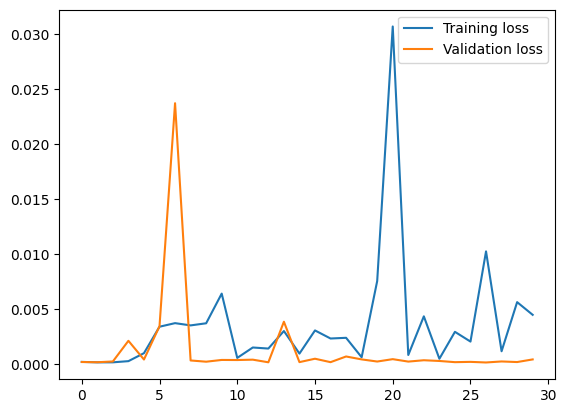

In [ ]:
# Try to load weights
try:
    model.load_weights('/content/drive/MyDrive/240410/1hr_dam_rnn_weights.h5')
    print("Loaded model weights from disk")
except:
    print("No weights found, training model from scratch")
    # Fit the model
    history = model.fit(trainX, trainY, epochs=30, batch_size=32,
                    validation_split=0.1, verbose=1)
    # Save model weights after training
    model.save_weights('/content/drive/MyDrive/240410/hr_dam_rnn_weights.h5')

    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.legend()
    plt.show()

575/575 [==============================] - 2s 3ms/step
[[0.00979336]
 [0.0097458 ]
 [0.01193378]
 ...
 [0.00983024]
 [0.01639204]
 [0.0066562 ]]


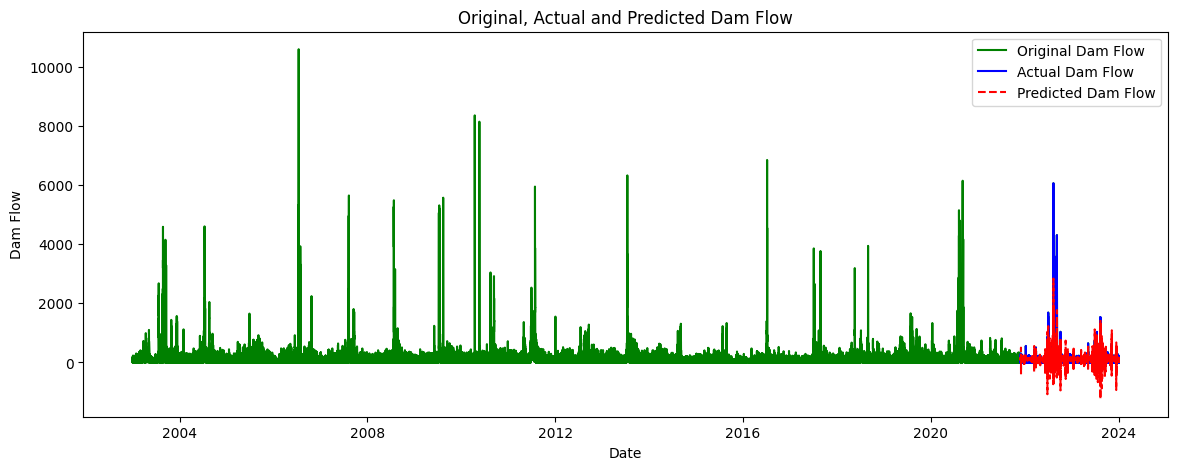

In [ ]:
prediction = model.predict(testX)
print(prediction)

y_pred = scaler_dam.inverse_transform(prediction)[:,0]
testY_original = scaler_dam.inverse_transform(testY)[:,0]

# mean_values_pred = np.repeat(scaler.mean_[np.newaxis, :], prediction.shape[0], axis=0)
# mean_values_pred[:, 0] = np.squeeze(prediction)
# y_pred = scaler.inverse_transform(mean_values_pred)[:,0]
# print(y_pred.shape)

# mean_values_testY = np.repeat(scaler.mean_[np.newaxis, :], testY.shape[0], axis = 0)
# mean_values_testY[:, 0] = np.squeeze(testY)
# testY_original = scaler.inverse_transform(mean_values_testY)[:, 0]
# print(testY_original.shape)

# plotting
plt.figure(figsize=(14, 5))

# plot original 'Open' prices
plt.plot(dates, original_dam, color='green', label='Original Dam Flow')

# plot actual vs predicted
plt.plot(test_dates[seq_len:], testY_original, color='blue', label='Actual Dam Flow')
plt.plot(test_dates[seq_len:], y_pred, color='red', linestyle='--', label='Predicted Dam Flow')
plt.xlabel('Date')
plt.ylabel('Dam Flow')
plt.title('Original, Actual and Predicted Dam Flow')
plt.legend()
plt.show()

In [ ]:
testDates = pd.DataFrame(test_dates)
pred_y = pd.DataFrame(y_pred)
original_y = pd.DataFrame(testY_original)

print(len(testDates), len(pred_y), len(original_y))

rnn_include_dam = pd.concat([testDates, original_y, pred_y], axis = 1)
print(rnn_include_dam)

rnn_include_dam = pd.DataFrame(rnn_include_dam)
rnn_include_dam.to_csv("/content/drive/MyDrive/240410/compare_dam/rnn_include_dam.csv")

18411 18387 18387
                      date        0           0
165693 2021-11-24 21:00:00      NaN         NaN
165694 2021-11-24 22:00:00      NaN         NaN
165695 2021-11-24 23:00:00      NaN         NaN
165696 2021-11-25 00:00:00      NaN         NaN
165697 2021-11-25 01:00:00      NaN         NaN
...                    ...      ...         ...
18382                  NaT  173.106   28.025248
18383                  NaT    0.000  143.387848
18384                  NaT  124.118  172.758331
18385                  NaT   15.417   92.918564
18386                  NaT    0.000  231.164017

[36798 rows x 3 columns]


In [ ]:
testX_last = []

for x in testX:
  testX_last.append(x[-1])

print(testX_last[0])

testX_last = scaler.inverse_transform(testX_last)
testX_last = pd.DataFrame(testX_last)

rnn_include_x = pd.concat([testDates, testX_last, original_y, pred_y], axis = 1)
rnn_include_x.to_csv("/content/drive/MyDrive/240410/compare_dam/rnn_include_x.csv")

print(rnn_include_x)

[0.00600609 0.         0.         0.         0.         0.        ]
                      date        0    1    2    3    4    5        0  \
165693 2021-11-24 21:00:00      NaN  NaN  NaN  NaN  NaN  NaN      NaN   
165694 2021-11-24 22:00:00      NaN  NaN  NaN  NaN  NaN  NaN      NaN   
165695 2021-11-24 23:00:00      NaN  NaN  NaN  NaN  NaN  NaN      NaN   
165696 2021-11-25 00:00:00      NaN  NaN  NaN  NaN  NaN  NaN      NaN   
165697 2021-11-25 01:00:00      NaN  NaN  NaN  NaN  NaN  NaN      NaN   
...                    ...      ...  ...  ...  ...  ...  ...      ...   
18382                  NaT   21.177  1.6  0.0  0.0  0.0  0.0  173.106   
18383                  NaT  173.106  0.0  0.0  0.0  0.0  0.0    0.000   
18384                  NaT    0.000  0.0  0.0  0.0  0.0  0.0  124.118   
18385                  NaT  124.118  0.0  0.0  0.0  0.0  0.0   15.417   
18386                  NaT   15.417  0.0  0.0  0.0  0.0  0.0    0.000   

                 0  
165693         NaN  
165694       

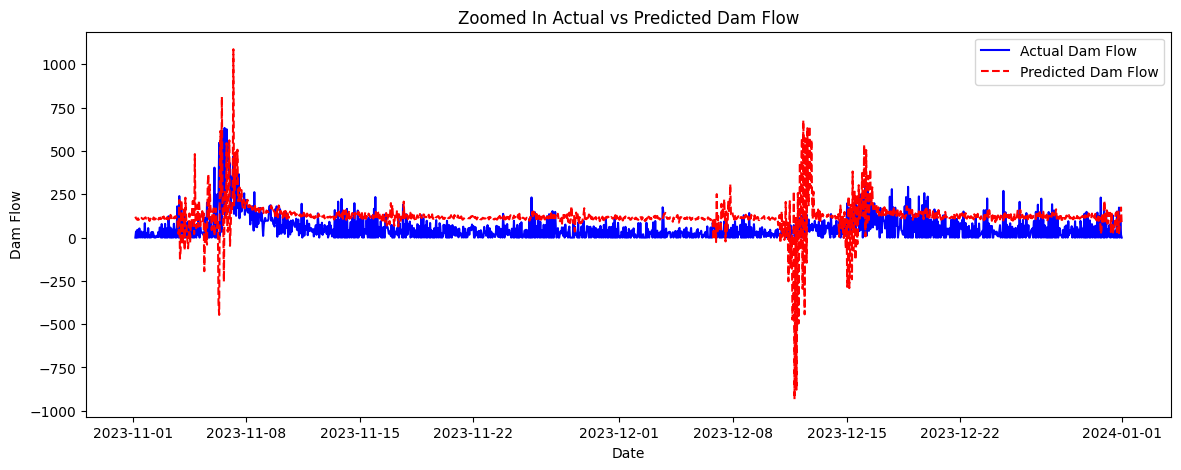

In [ ]:
# Calculate the start and end indices for the zoomed plot
zoom_start = len(test_dates) - 365*4
zoom_end = len(test_dates)

# Create the zoomed plot
plt.figure(figsize=(14, 5))

# Adjust the start index for the testY_original and y_pred arrays
adjusted_start = zoom_start - seq_len

plt.plot(test_dates[zoom_start:zoom_end],
         testY_original[adjusted_start:zoom_end - zoom_start + adjusted_start],
         color='blue',
         label='Actual Dam Flow')

plt.plot(test_dates[zoom_start:zoom_end],
         y_pred[adjusted_start:zoom_end - zoom_start + adjusted_start ],
         color='red',
         linestyle='--',
         label='Predicted Dam Flow')

plt.xlabel('Date')
plt.ylabel('Dam Flow')
plt.title('Zoomed In Actual vs Predicted Dam Flow')
plt.legend()
plt.show()

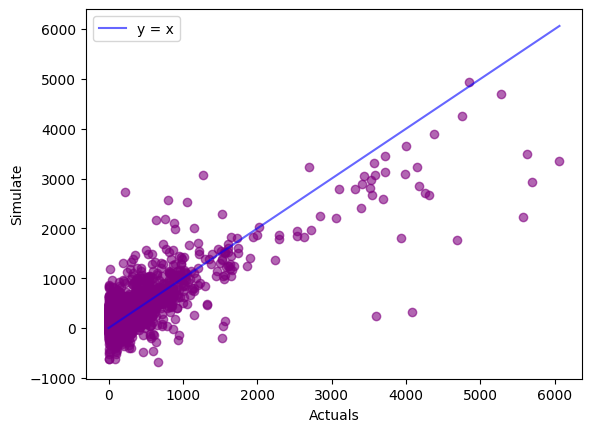

In [ ]:
# 일대일 그래프
x = np.arange(0,max(max(testY_original), max(y_pred)))
y = x
plt.scatter(testY_original[:], y_pred[:], color = 'purple', alpha = 0.6)
plt.plot(x,y, color = 'blue', alpha = 0.6, label = 'y = x')
plt.xlabel('Actuals')
plt.ylabel('Simulate')

plt.legend()
plt.show()

In [ ]:
#RMSE
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(testY_original, y_pred))
print('RMSE : %.2f' %(rmse))

RMSE : 131.92


In [ ]:
# NSE
from numpy import mean
num_sum1 = 0
num_sum2 = 0
num_avg = mean(testY_original[:])
for i in range(len(testY_original)):
  num1 = testY_original[i] - y_pred[i]
  num_sum1 += num1**2
  num2 = testY_original[i] - num_avg
  num_sum2 += num2**2

nse = 1 - (num_sum1 / num_sum2)
print('NSE : %f' %nse)

NSE : 0.667122


In [ ]:
# PBIAS
num_sum1 = 0
for i in range(len(testY_original)):
  num1 = testY_original[i] - y_pred[i]
  num_sum1 += num1

pbias = (num_sum1 / np.sum(testY_original[:])) * 100
print('PBIAS : %f' %pbias)

PBIAS : -15.083366


In [ ]:
#R^2
import math

num_sum1 = 0
num_sum2 = 0
num_sum3 = 0
act_avg = mean(testY_original[:])
pred_avg = mean(y_pred[:])
for i in range(len(testY_original)):
  num1 = (testY_original[i] - act_avg) * (y_pred[i] - pred_avg)
  num_sum1 += num1
  num2 = testY_original[i] - pred_avg
  num_sum2 += num2**2
  num3 = y_pred[i] - pred_avg
  num_sum3 += num3**2

r_square = (num_sum1 / (math.sqrt(num_sum2)* math.sqrt(num_sum3)))**2
print('R Square : %f' %r_square)

R Square : 0.673478
